# Выявление закономерностей, определяющих успешность компьютерной игры.<a class="tocSkip">

**Цель проекта - определить факторы, влияющие на успешность игры, основываясь на исторических данных о продажах игр, оценке пользователей и экспертов, жанрах и платформах. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.**

### Оглавление.<a class="tocSkip">

[Открытие данных](#step1)

[Предобработка данных](#step2)

[1. Изменение названий столбцов](#step2.1)

[2. Изменение типов данных](#step2.2)

[3. Обработка пропусков](#step2.3)

[4. Расчет суммарных продаж](#step2.4)

[Исследовательский анализ данных](#step3)

[1. Определение *актуального периода* для игровых платформ](#step3.1)

[2. Выбор потенциально прибыльных платформ](#step3.2)

[3. Изучение влияния отзывов пользователей и критиков на продажи](#step3.3)

[4. Общее распределение продаж по жанрам](#step3.4)

[Составление портрета пользователя каждого региона](#step4)

[1. Топ-5 платформ](#step4.1)

[2. Топ-5 жанров](#step4.2)

[3. Влияние рейтинга ESRB](#step4.3)

[Проверка гипотез](#step5)

[1. Гипотеза 'средние пользовательские рейтинги платформ Xbox One и PC одинаковые'](#step5.1)

[2. Гипотеза 'cредние пользовательские рейтинги жанров Action и Sports разные.'](#step5.2)

[Общий вывод](#step6)

<a id="step1"></a>
## Открытие данных<a class="tocSkip">

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
import numpy as np
import scipy.stats as st

In [2]:
df = pd.read_csv('/datasets/games.csv')

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Данные открыты, переходим к предобработке.**

In [4]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


<a id="step2"></a>
## Предобработка данных<a class="tocSkip">

<a id="step2.1"></a>
### 1. Изменений названий столбцов<a class="tocSkip">

**Приводим названия столбцов к нижнему регистру.**

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

<a id="step2.2"></a>
### 2. Изменение типов данных<a class="tocSkip">

In [7]:
df.isna().mean()

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.400897
rating             0.404786
dtype: float64

**В столбце 'year_of_release' значения отображаются в некоректном формате, т.к. здесь только год достаточно привести их в целочисленный вид. Кроме того имеются пропущенные значения, но ввиду того, что нет возможности восстановить истинное значение, и их количество невелико (1,6%),  заменим их 1, чтобы пропуски не мешали дальнейшим расчетам.**

In [8]:
df['year_of_release'] = df['year_of_release'].fillna(1).astype(int)

In [9]:
df.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN


<a id="step2.3"></a>
###  3. Обработка пропусков<a class="tocSkip">

**В столбцах с рейтингами значительное (40% - 51%) количество пропусков, так же два значения в столбцах 'name' и 'genre', но мы не имеем возможности найти им обоснованную замену, поэтому оставляем их без изменений.**

In [10]:
df.query('user_score == "tbd"').sample(4)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
7163,Cloudy With a Chance of Meatballs,DS,2009,Platform,0.20,0.01,0.0,0.02,NaN,tbd,E
11759,Party Pigs: Farmyard Games,Wii,2009,Misc,0.07,0.00,0.0,0.00,NaN,tbd,E
9529,Rock Band Track Pack Volume 1,PS2,2008,Misc,0.06,0.05,0.0,0.02,NaN,tbd,T
10101,The Hardy Boys: Treasure on the Tracks,DS,2009,Adventure,0.10,0.00,0.0,0.01,65.0,tbd,E


**Кроме того в столбце 'user_score' в 2424 строках указано значение 'tbd' - оценка еще не подсчитана, здесь, вероятно, единственной разумной заменой будет 'NaN'.**

In [11]:
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

<a id="step2.4"></a>
###  4. Расчет суммарных продаж<a class="tocSkip">

**Расчитаем суммарные продажи во всех регионах и занесем их в отдельный столбец.**

In [12]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [13]:
df = df[['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'total_sales', 'critic_score', 'user_score', 'rating']]

In [14]:
df.sample(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,total_sales,critic_score,user_score,rating
8461,Blood Bowl,X360,2009,Sports,0.13,0.02,0.00,0.16,61.0,5.1,T
5236,South Park Rally,PS,1998,Racing,0.20,0.13,0.00,0.35,NaN,NaN,NaN
16168,War for the Overworld,PC,2015,Strategy,0.00,0.01,0.00,0.01,65.0,7.7,NaN
2395,NHL 2000,PS,1998,Sports,0.48,0.33,0.00,0.87,NaN,NaN,NaN
1225,Mario Golf: Toadstool Tour,GC,2003,Sports,1.09,0.15,0.25,1.53,81.0,8.0,E
7757,Spectrobes: Origins,Wii,2009,Role-Playing,0.16,0.02,0.00,0.19,71.0,8.4,E10+
15148,Resident Evil: Umbrella Corps,PS4,2016,Action,0.00,0.00,0.02,0.02,NaN,NaN,NaN
10851,NatGeo Challenge! Wild Life,PS3,2010,Misc,0.05,0.03,0.00,0.09,NaN,NaN,NaN
12464,Guilty Gear XX Accent Core Plus,PS2,2008,Fighting,0.03,0.02,0.00,0.06,NaN,8.0,T
1995,F-Zero: Maximum Velocity,GBA,2001,Racing,0.39,0.16,0.37,1.04,86.0,8.5,E


**Предварительная обработка данных завершена.**

<a id="step3"></a>
## Исследовательский анализ данных<a class="tocSkip">

<a id="step3.1"></a>
### 1. Определение *актуального периода* для игровых платформ<a class="tocSkip">

**Посмотрим,  сколько игр выпускалось в разные годы.**

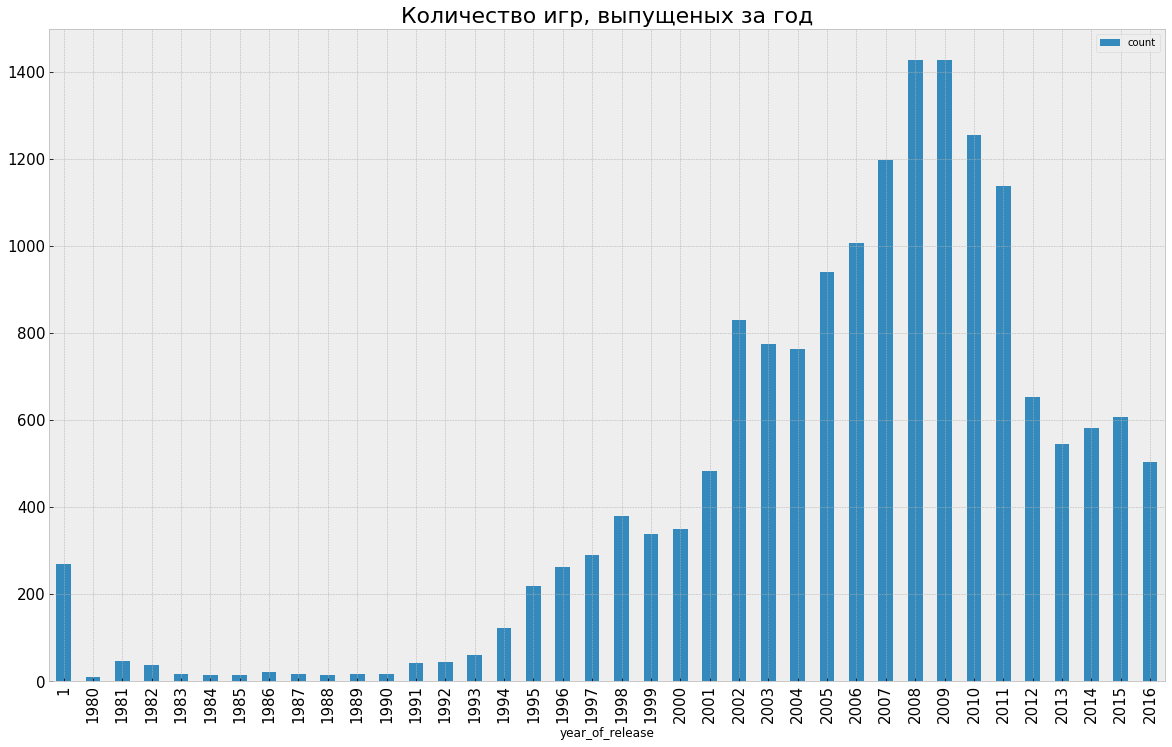

In [15]:
df.groupby(['year_of_release'])['name'].agg(['count'])\
.plot(kind='bar',figsize=(20, 12),grid=True,fontsize=15)
plt.title('Количество игр, выпущеных за год', fontsize=22)
plt.show()

**На графике мы видим, что до середины 90-х предложенние на рынке компьютерных игр не отличалось разнобразием,  затем следует рост количества выпускаемых игр. Данные до 1995 г. можем не учитывать.**

In [16]:
df = df.query('year_of_release > 1994')

**Определим платформы с наибольшими суммарными продажами**

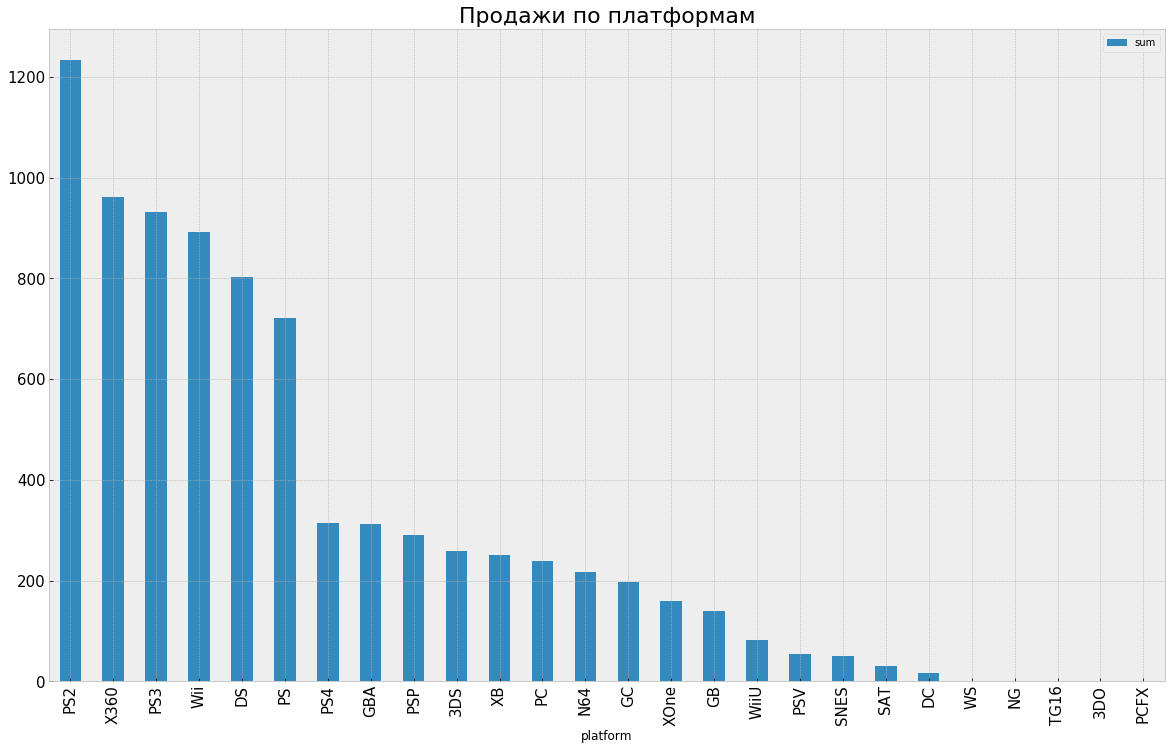

In [17]:
df.groupby(['platform'])['total_sales'].agg(['sum']).sort_values(by = 'sum', ascending = False)\
.plot(kind='bar',figsize=(20, 12), grid=True,fontsize=15)
plt.title('Продажи по платформам', fontsize=22)
plt.show()

**Выдделим 10 наиболее успешных платформ.**

In [18]:
top_10 = df.groupby(['platform'])['total_sales'].agg(['sum']).sort_values(by = 'sum', ascending = False).head(10)

In [19]:
platform_name = top_10.index

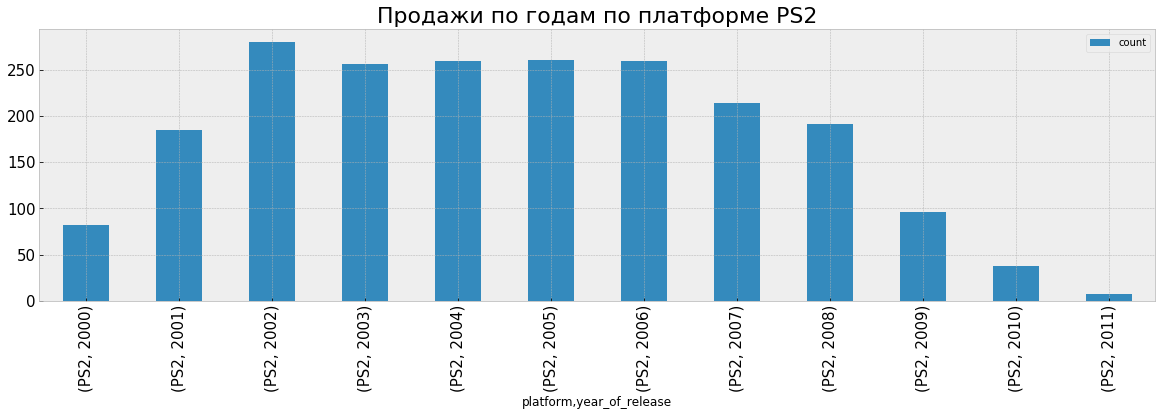

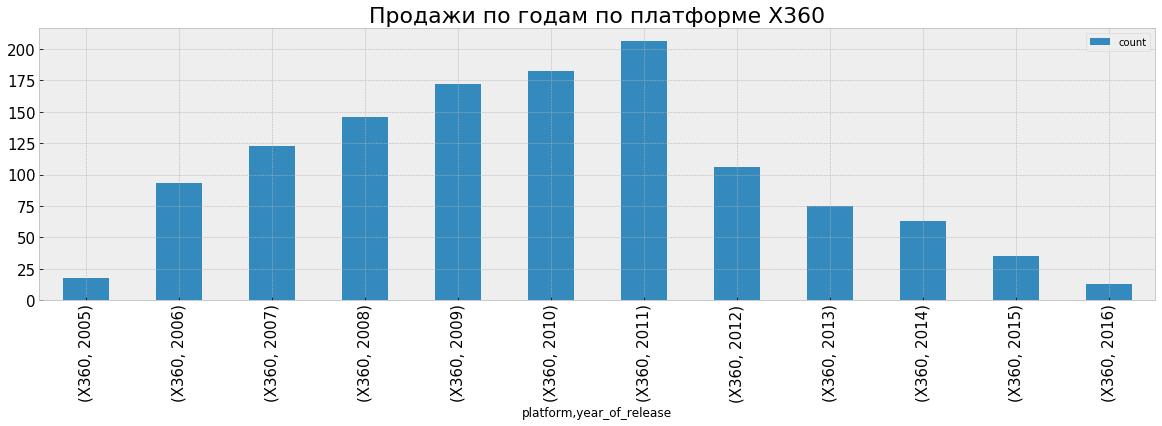

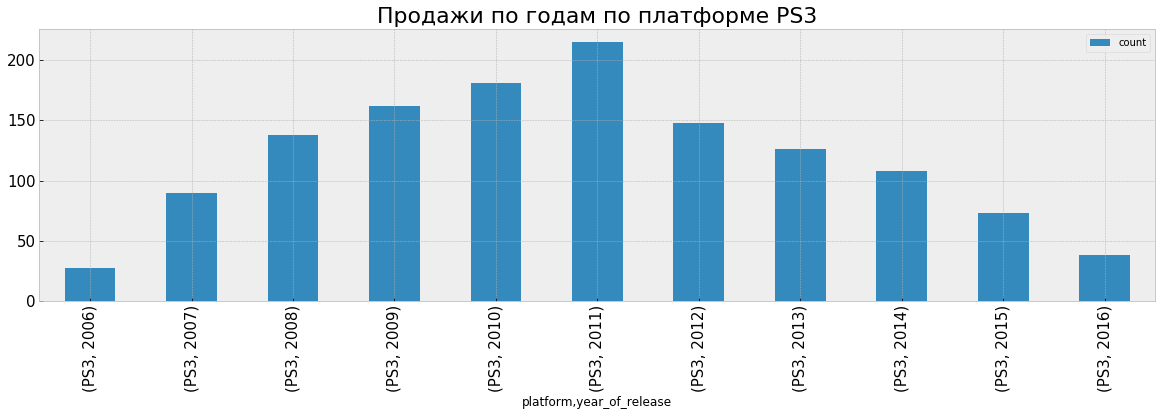

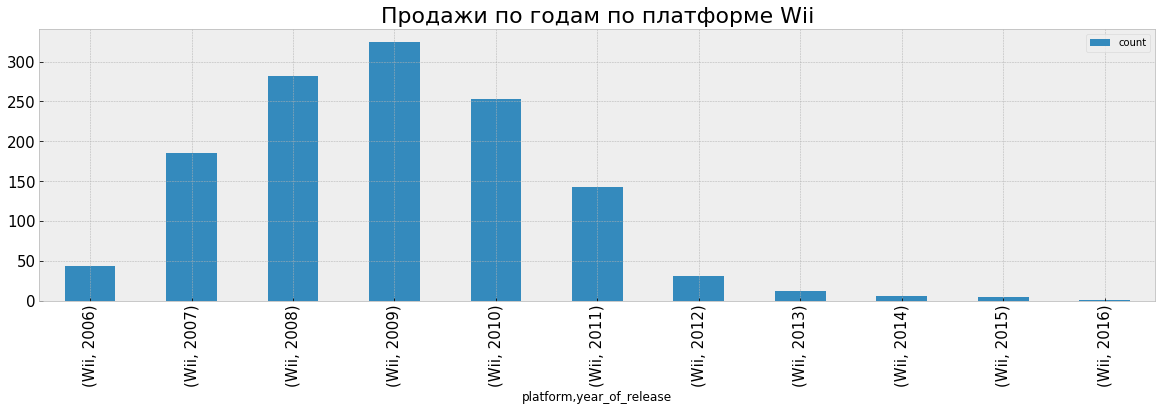

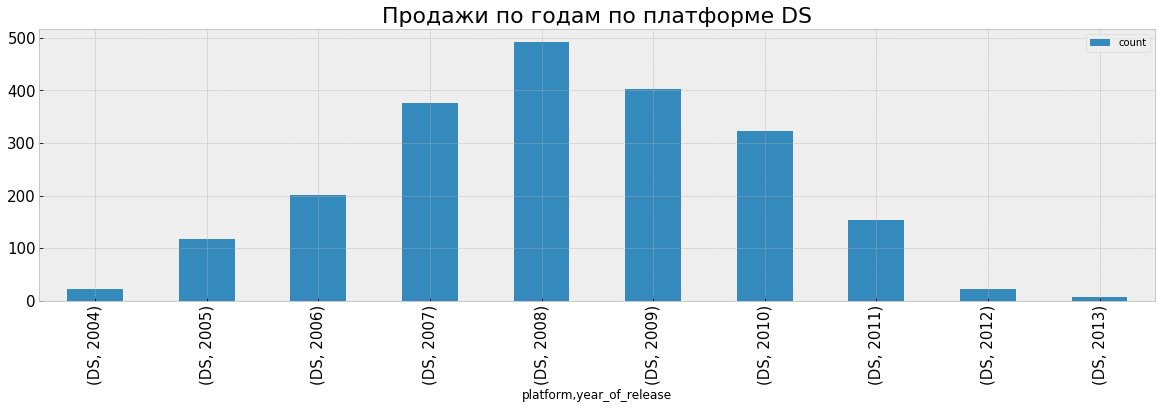

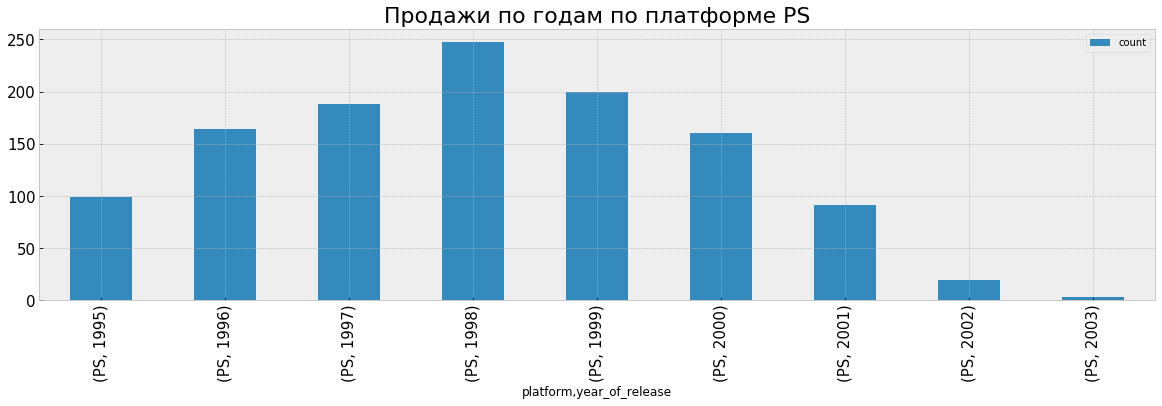

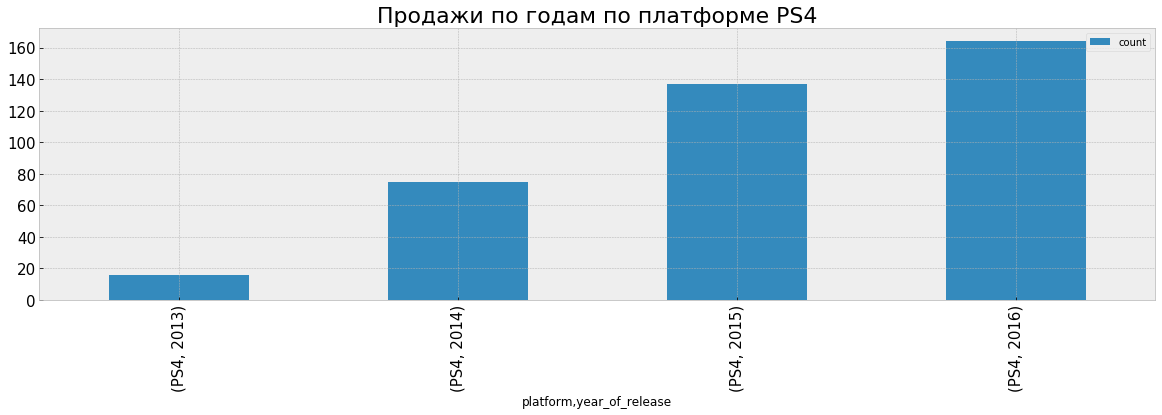

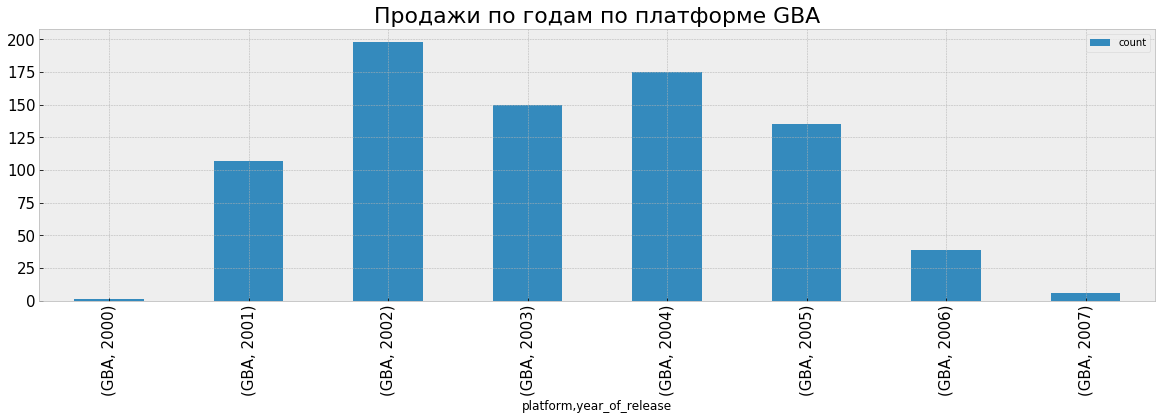

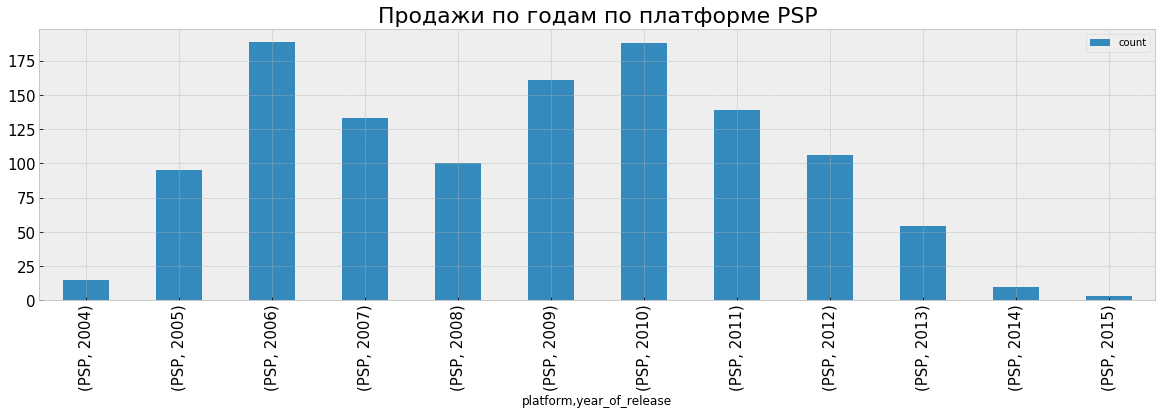

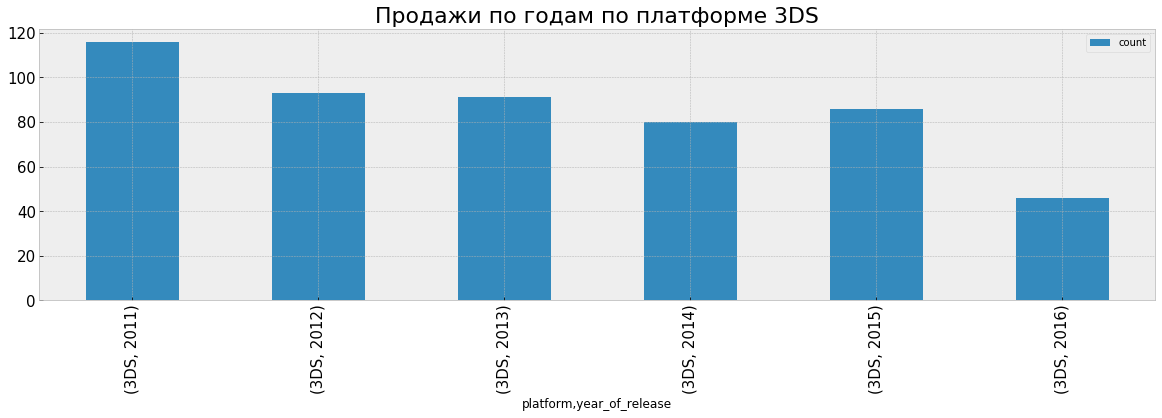

In [20]:
for i in top_10.index:
    platform_name = i
    df.groupby(['platform', 'year_of_release'])['name'].agg(['count']).query('platform == @platform_name')\
    .plot.bar(grid=True, figsize=(20, 5),fontsize=15)
    plt.title(f'Продажи по годам по платформе {platform_name}', fontsize=22)
plt.show()

**По результатам построенния графиков можно сказать, что средний 'срок жизни' платформ 5-10 лет.**

**Изходя из этого выбираем *актуальный период* 7 лет. данные за предыдущие годы не будем учитывать**

In [21]:
df_new = df.query('year_of_release > 2009')

In [22]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5277 entries, 14 to 16714
Data columns (total 11 columns):
name               5277 non-null object
platform           5277 non-null object
year_of_release    5277 non-null int64
genre              5277 non-null object
na_sales           5277 non-null float64
eu_sales           5277 non-null float64
jp_sales           5277 non-null float64
total_sales        5277 non-null float64
critic_score       2312 non-null float64
user_score         2499 non-null float64
rating             3113 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 494.7+ KB


**Объем данных существенно сократился**

<a id="step3.2"></a>
### 2. Выбор потенциально прибыльных платформ<a class="tocSkip">

**Выберем платформы, растущие в данный период.**

In [23]:
new_top_10 = df_new.groupby(['platform'])['total_sales'].agg(['sum'])\
.sort_values(by = 'sum', ascending = False).head(10)

In [24]:
platform_name = new_top_10.index

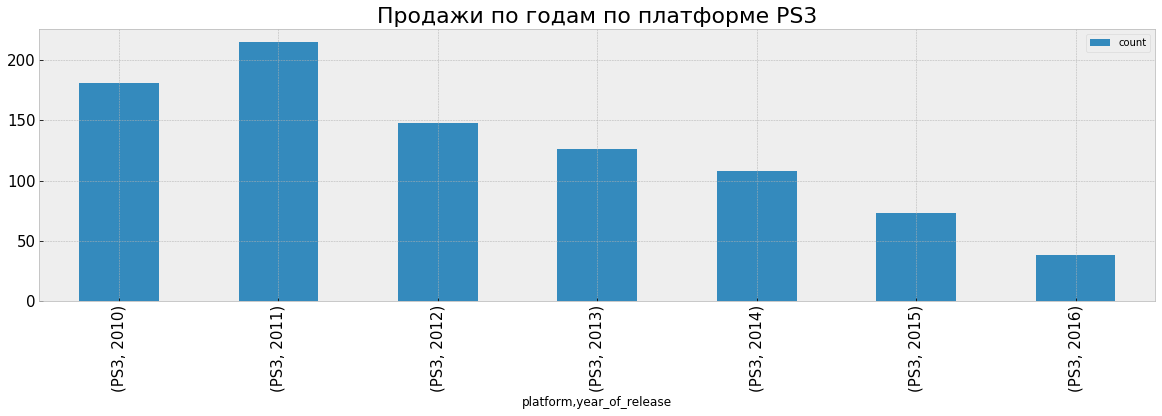

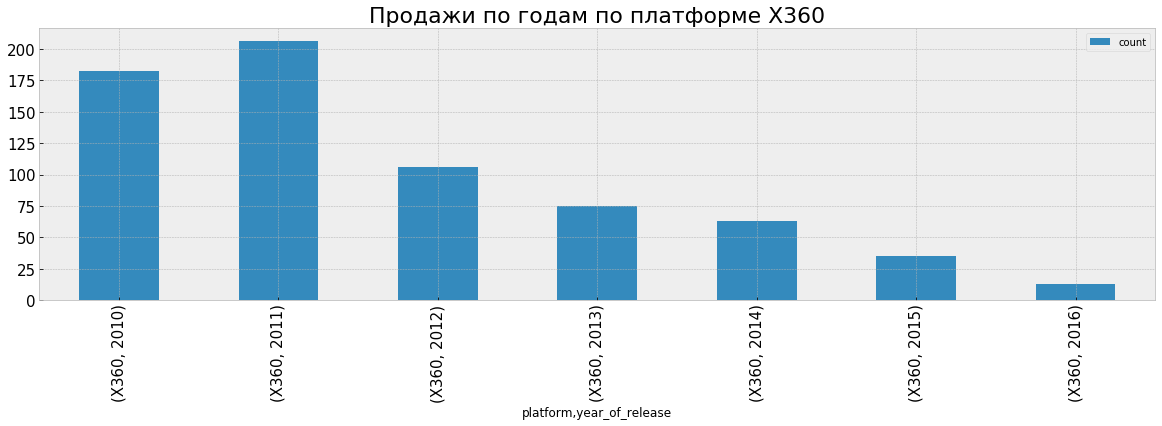

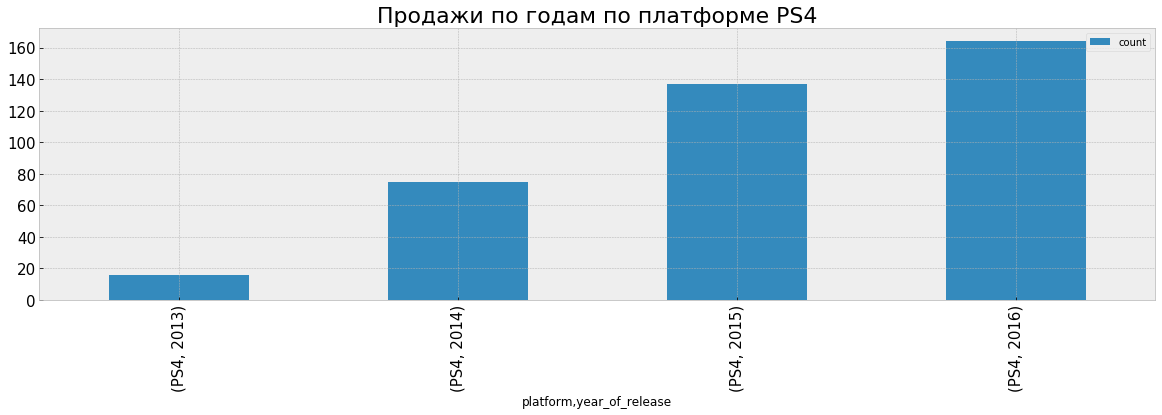

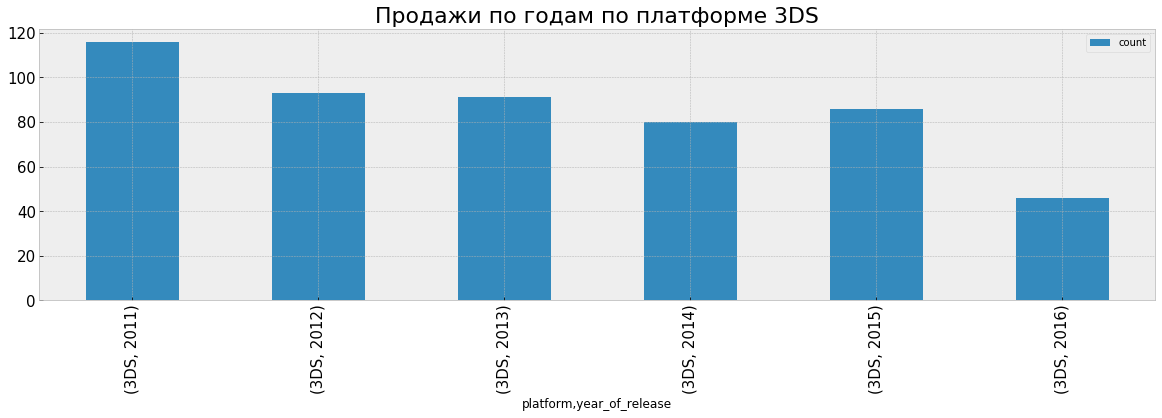

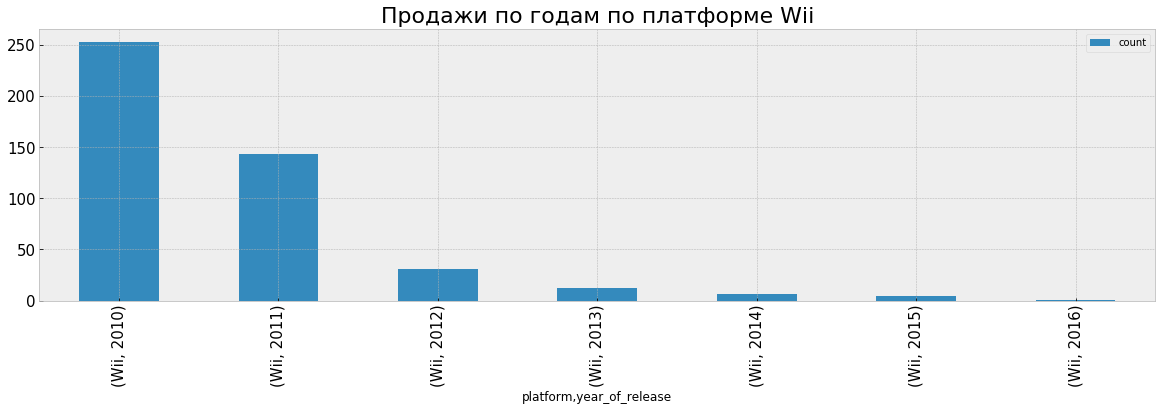

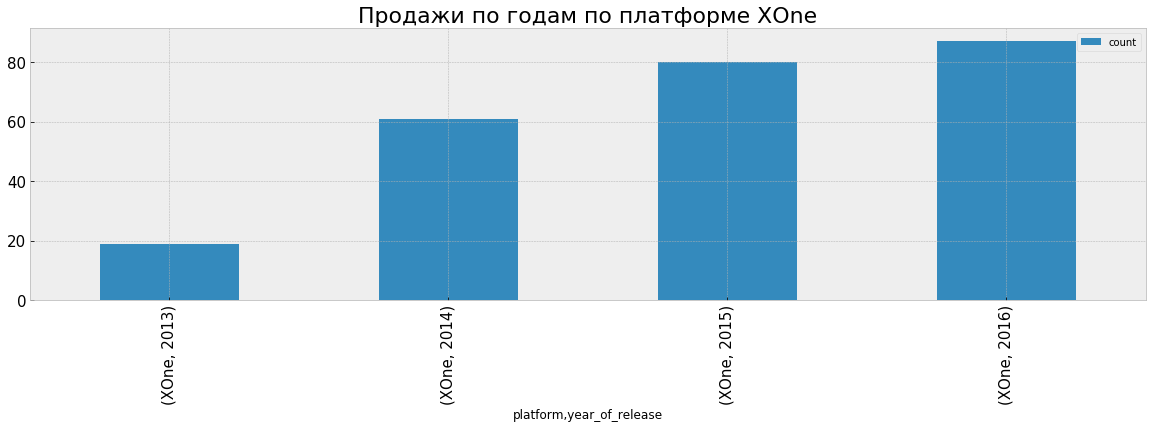

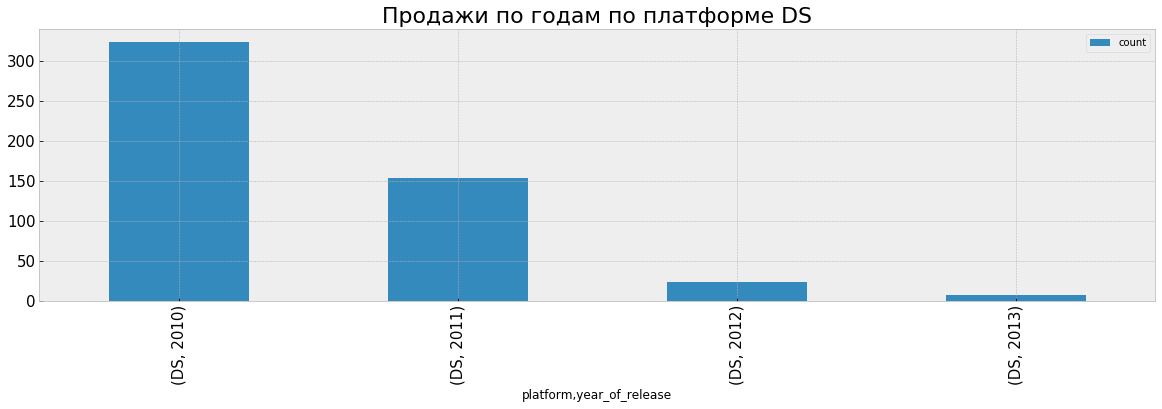

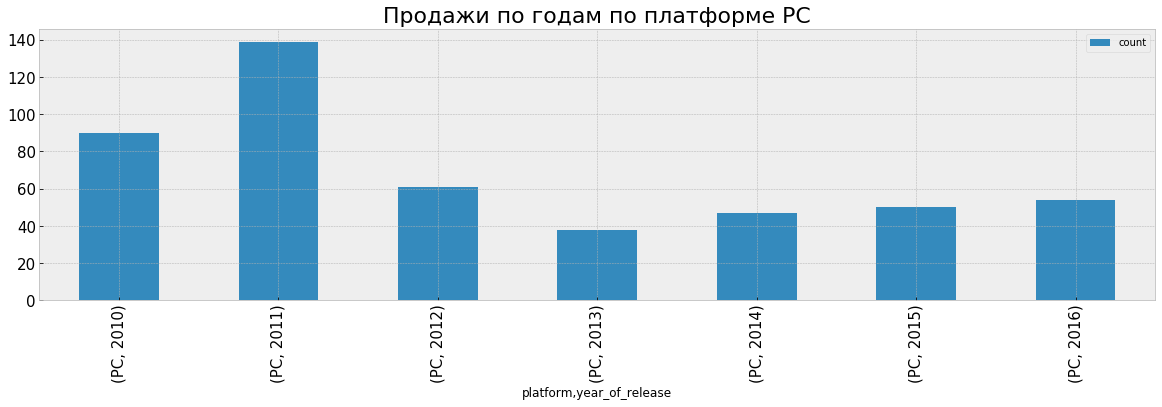

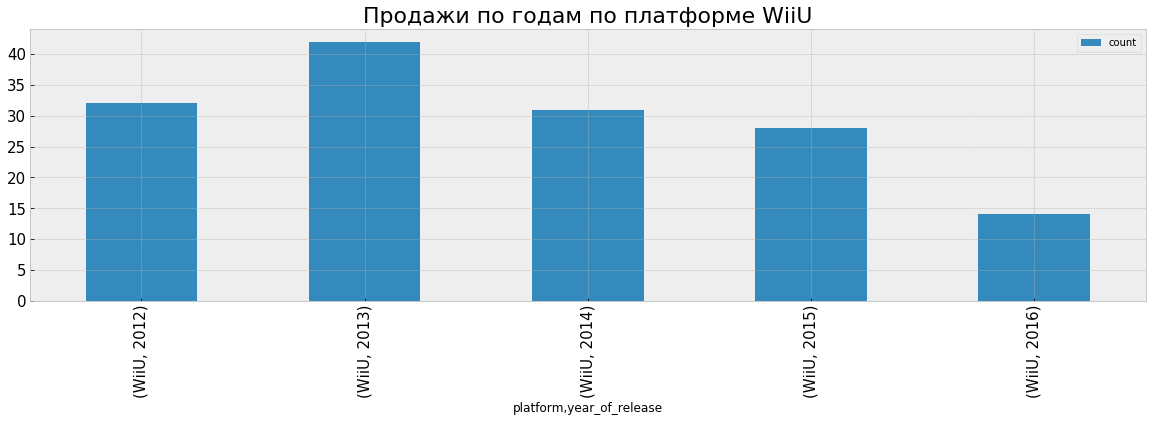

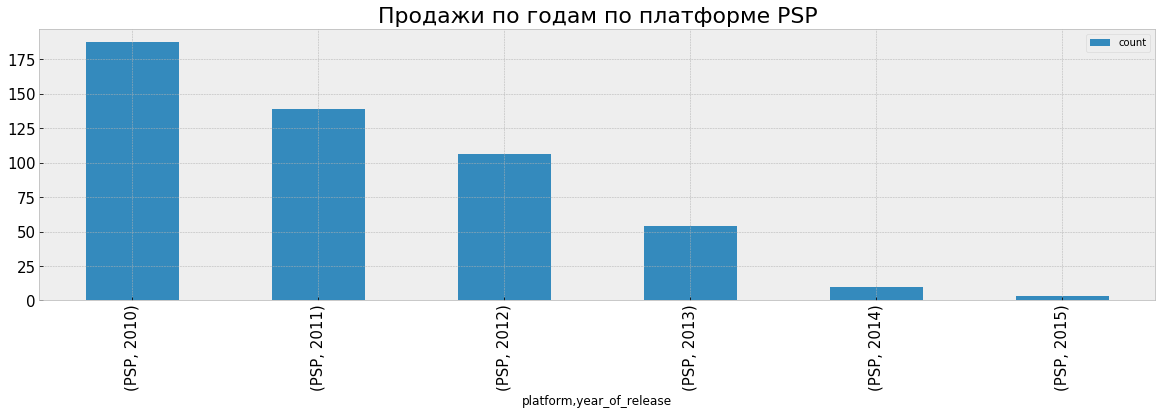

In [25]:
for i in new_top_10.index:
    platform_name = i
    df_new.groupby(['platform', 'year_of_release'])['name'].agg(['count']).query('platform == @platform_name')\
    .plot.bar(grid=True, figsize=(20, 5),fontsize=15)
    plt.title(f'Продажи по годам по платформе {platform_name}', fontsize=22)
    plt.show()

**В результате изучения построенных графиков однозначно можно назвать наиболее перспективными платформы 'PS4', 'XOne',кроме того 'PС', - после падения 2012-2013 г.г. возобновился рост.**

**Построим диаграммы размаха.**

In [26]:
platform_dict = ['PS4', 'PC', 'XOne']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


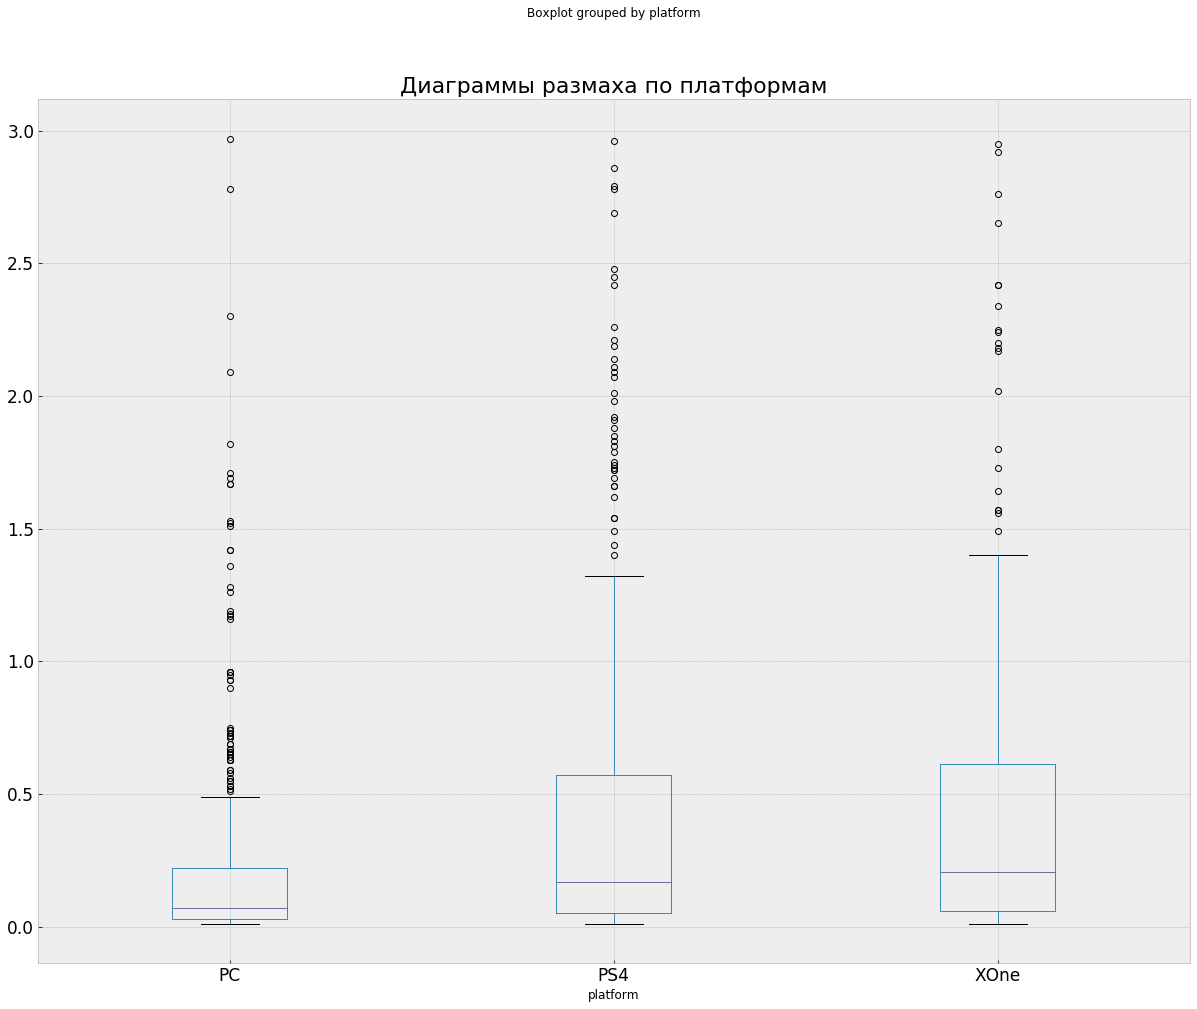

In [52]:
plot = df_new.query('total_sales<3')[df_new.platform.isin(platform_dict)]\
.boxplot('total_sales', by='platform', figsize=(20, 16), fontsize=17)
plt.title('Диаграммы размаха по платформам', fontsize=22)
plt.grid(True)
plt.show()

**Если не принимать во внимание максимальные значения, диаграммы размаха для 'PS4' и 'XOne' отличаются мало, 'PC' - существенно отстает от лидеров.**

<a id="step3.3"></a>
### 3. Изучение влияния отзывов пользователей и критиков на продажи.<a class="tocSkip">

**Построим диаграмму рассеяния продаж в зависимости от отзывов пользователей и критиков для платформы 'XOne'**

In [28]:
score_dict = {'critic_score', 'user_score'}

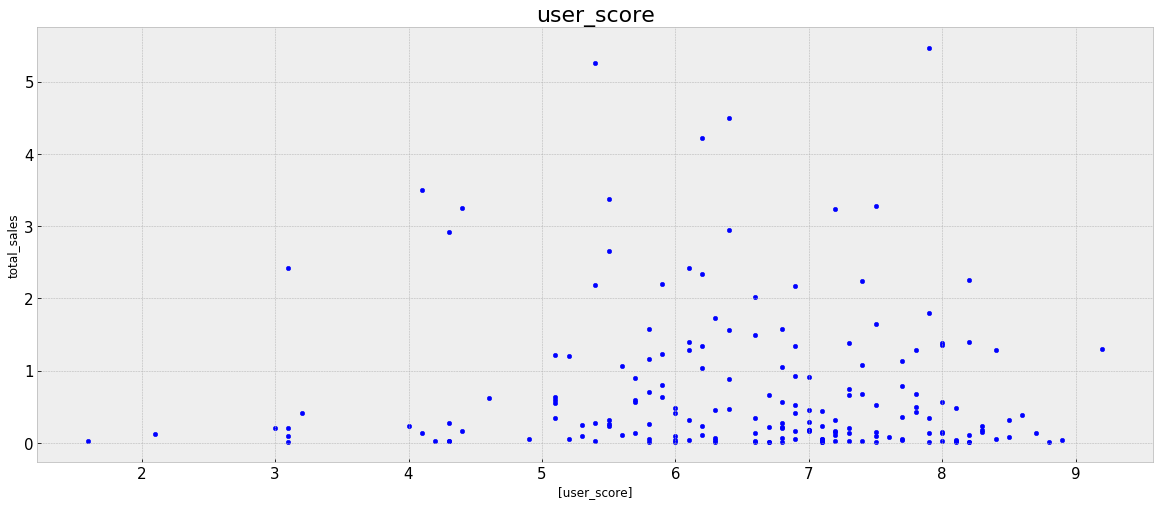

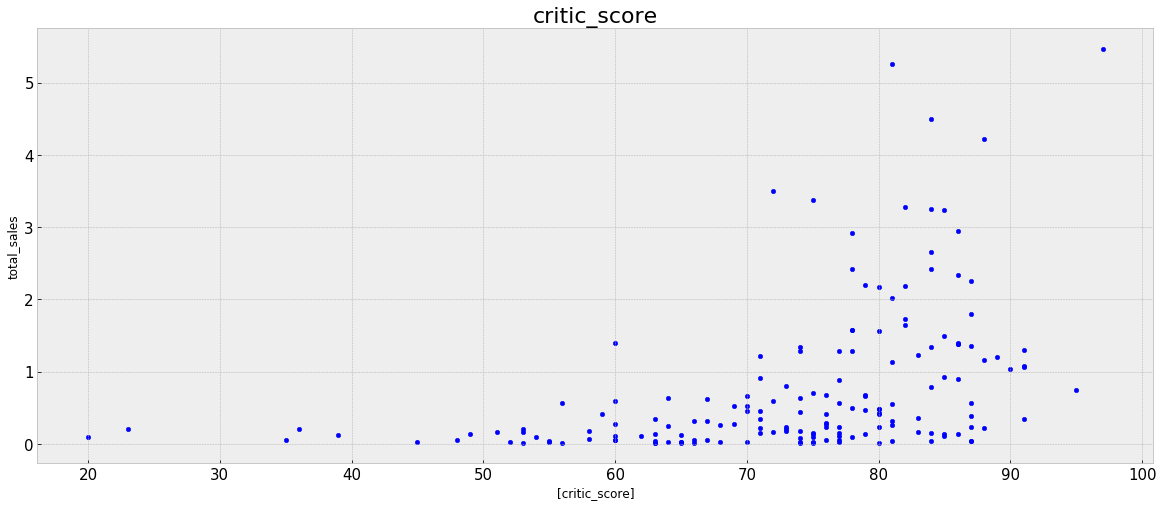

In [29]:
for i in score_dict:
    score_dict = i
    df_new.query('platform == "XOne"').plot(y='total_sales', x=[score_dict], kind='scatter',figsize=(20, 8),\
                                            fontsize=15)
    plt.title(score_dict, fontsize=22)
    plt.show()

**Расчитаем корреляцию для данных значений**

In [30]:
df_new.query('platform == "XOne"')['total_sales'].corr(df_new['critic_score'])

0.41699832800840175

In [31]:
df_new.query('platform == "XOne"')['total_sales'].corr(df_new['user_score'])

-0.06892505328279412

In [32]:
df_new.query('platform == "XOne" and critic_score != "NaN"')['total_sales'].corr(df_new['critic_score'])

0.41699832800840175

In [33]:
df_new.query('platform == "XOne" and user_score != "NaN"')['total_sales'].corr(df_new['user_score'])

-0.06892505328279412

**Диаграмма рассеяния и коэффициент корреляции для зависимости продаж от оценок критиков показывают вполне ожидаемую закономерность - чем выше рейтинги, тем лучше продажи. А вот в случае с пользовательскими отзывами все иначе - близкая к нолю отрицательная корреляция -0,0689, похоже пользователей мало интересует мнение других игроков, они больше пологаются на  рейтинги критиков.**

**Вероятно, на других платформах мы получили бы схожие результаты**

<a id="step3.4"></a>
### 4.Oбщее распределение продаж по жанрам<a class="tocSkip">

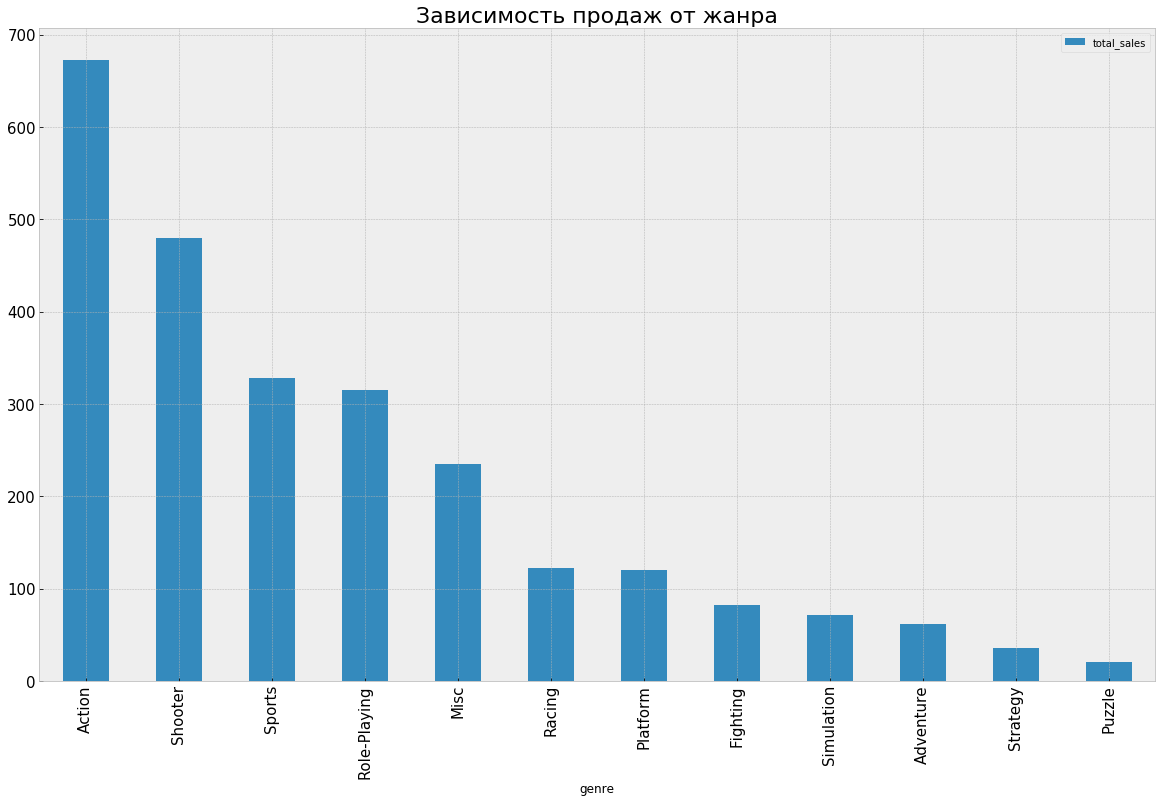

In [34]:
df_new.groupby('genre')[['total_sales']].sum().sort_values(by = 'total_sales', ascending = False)\
.plot(kind='bar',figsize=(20, 12),fontsize=15)
plt.title('Зависимость продаж от жанра', fontsize=22)
plt.show()

**Исходя из графика можно сказать, что самыми прибыльными жанрами являются 'Action', 'Shooter' и 'Sports', предпологающие динамичный сюжет, а "спокойные" 'Strategy' и 'Puzzle' - явные аутсайдеры, причем с колоссальным разрывом.**

<a id="step4"></a>
##  Составление портрета пользователя каждого региона<a class="tocSkip">

<a id="step4.1"></a>
### 1. Топ-5 платформ<a class="tocSkip">

**Определим самые популярные платформы для рзных регионов.**

In [35]:
sales_dict = {'na_sales': {'title': 'Продажи по платформам в Северной Америке'},\
              'eu_sales': {'title': 'Продажи по платформам в Европе'},\
              'jp_sales': {'title': 'Продажи по платформам в Японии'}}

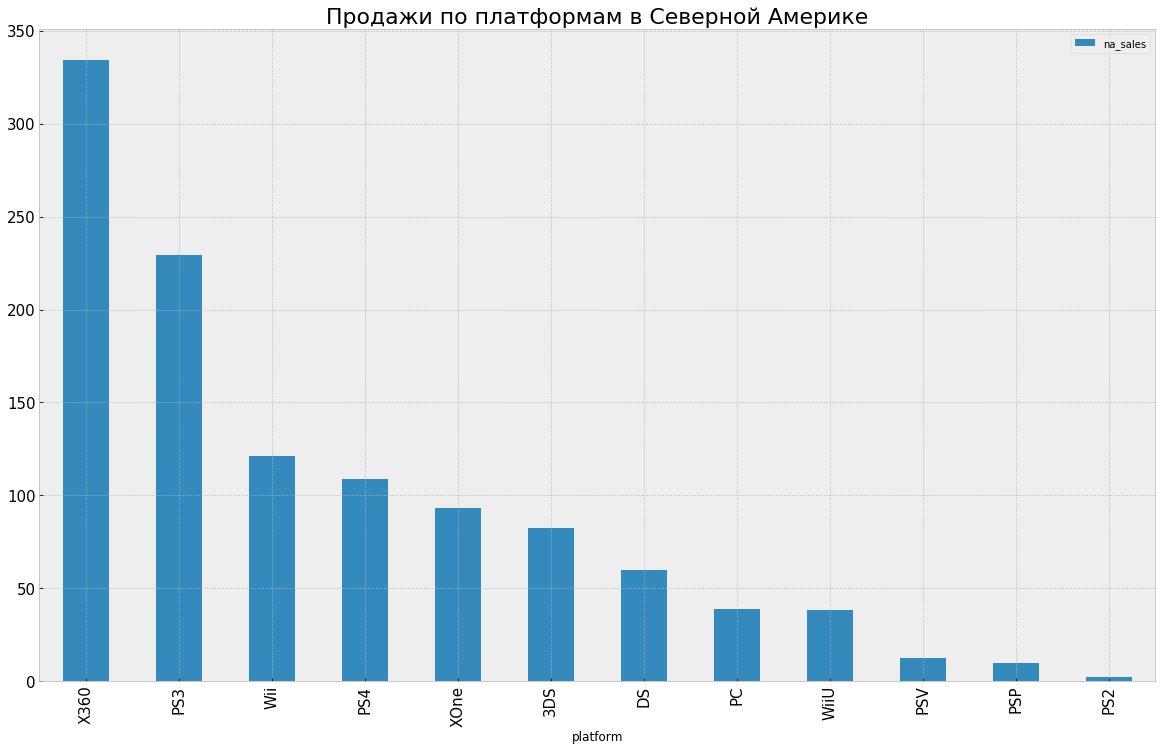

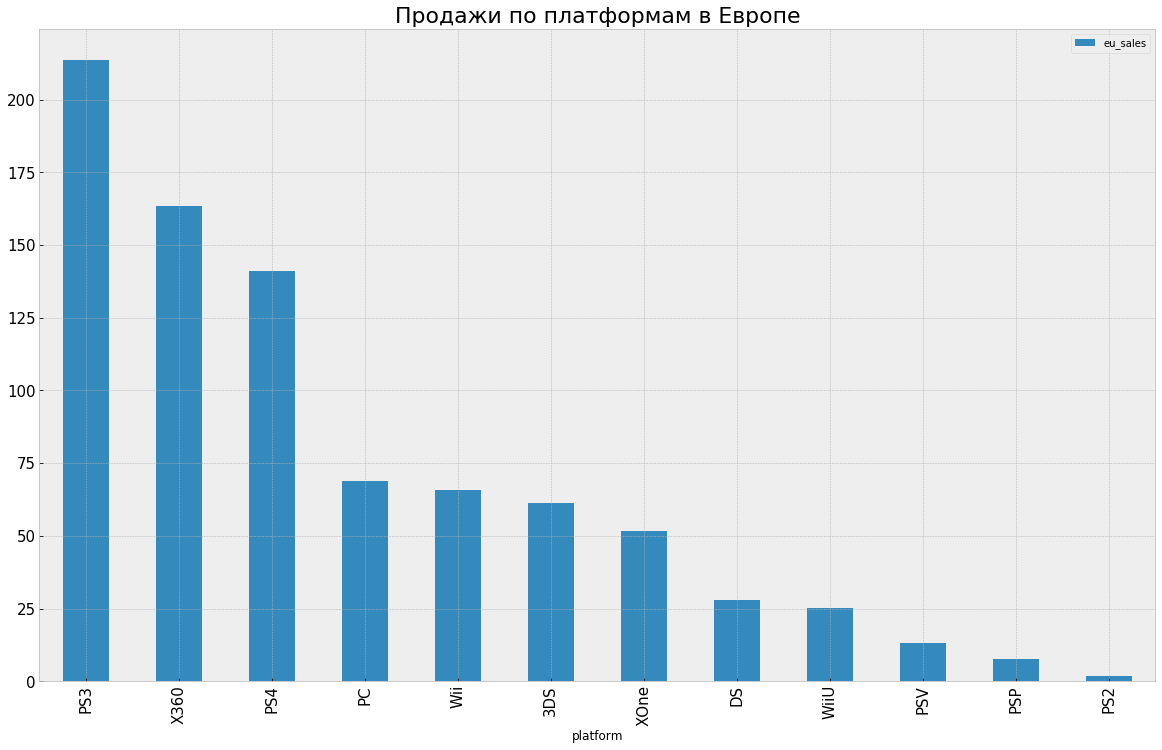

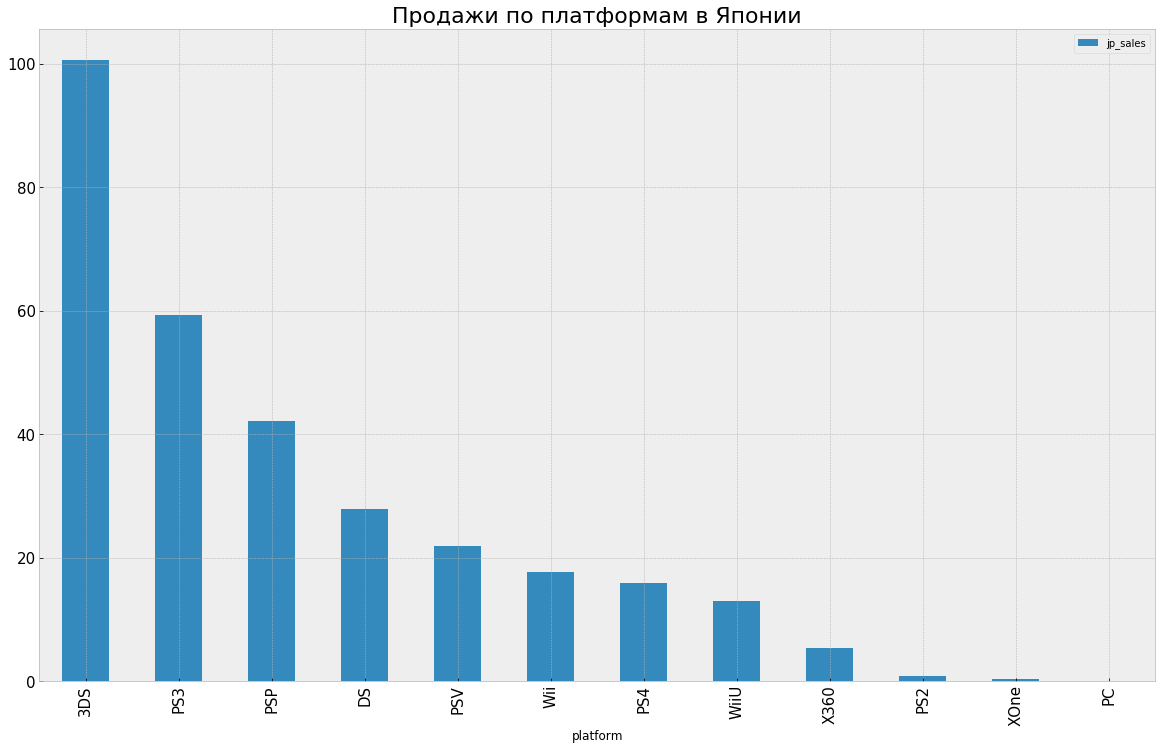

In [36]:
for key,value in sales_dict.items():
    df_new.groupby('platform')[[key]].sum().sort_values(by = [key], ascending = False)\
    .plot.bar(grid=True,figsize=(20, 12), fontsize=15)
    plt.title(value['title'],fontsize=22)
    plt.show()

**Диaграммы продаж для Северной Америки и Европы похожи - Топ-5 для Америки: 'X360', 'PS3', 'Wii', 'PS4', 'XOne', для Европы: 'PS3', 'X360', 'PS4', 'PC', 'Wii'. Для Японии совершенно другие резуьтаты: '3DS', 'PS3', 'PSP', 'DS' и 'PSV' сходство с предыдущими - только 'PS3' в Топ-5**

<a id="step4.2"></a>
### 2. Топ-5 жанров<a class="tocSkip">

**Определим самые популярнные жанры по регионам**

In [37]:
ganre_dict = {'na_sales': {'title': 'Продажи по жанрам в Северной Америке'},\
              'eu_sales': {'title': 'Продажи по жанрам в Европе'},\
              'jp_sales': {'title': 'Продажи по жанрам в Японии'}}

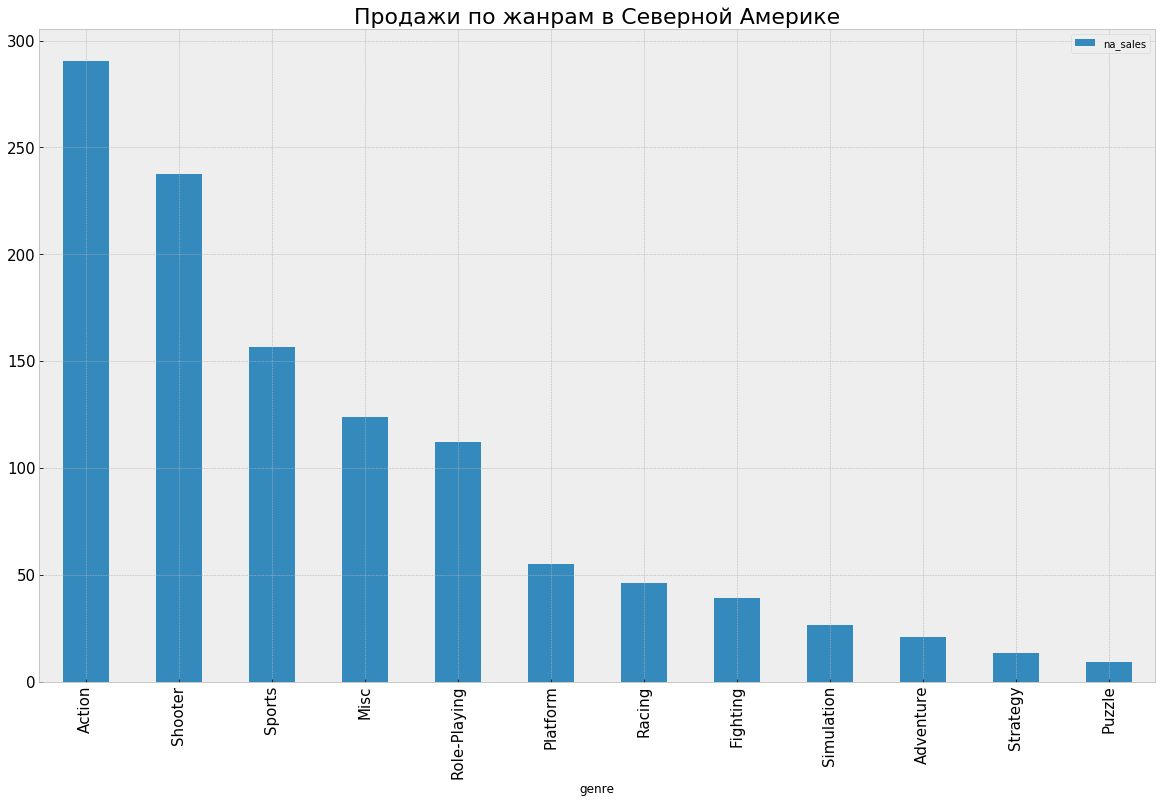

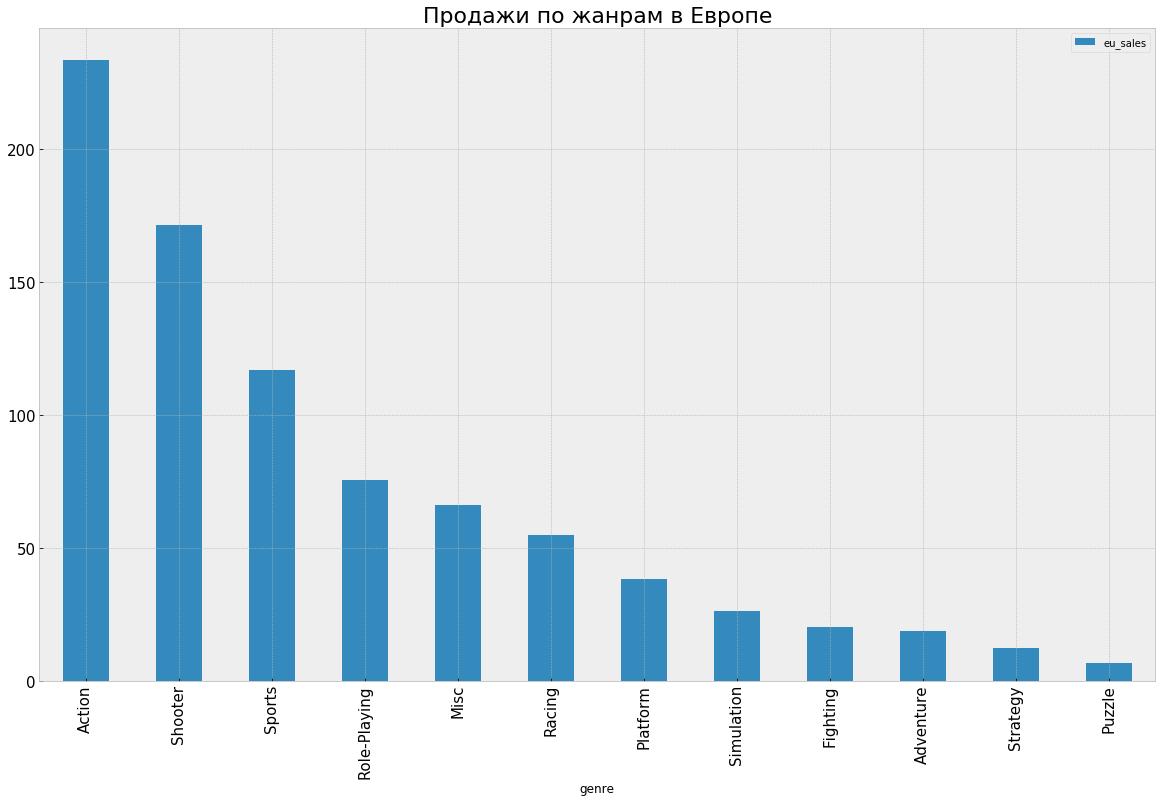

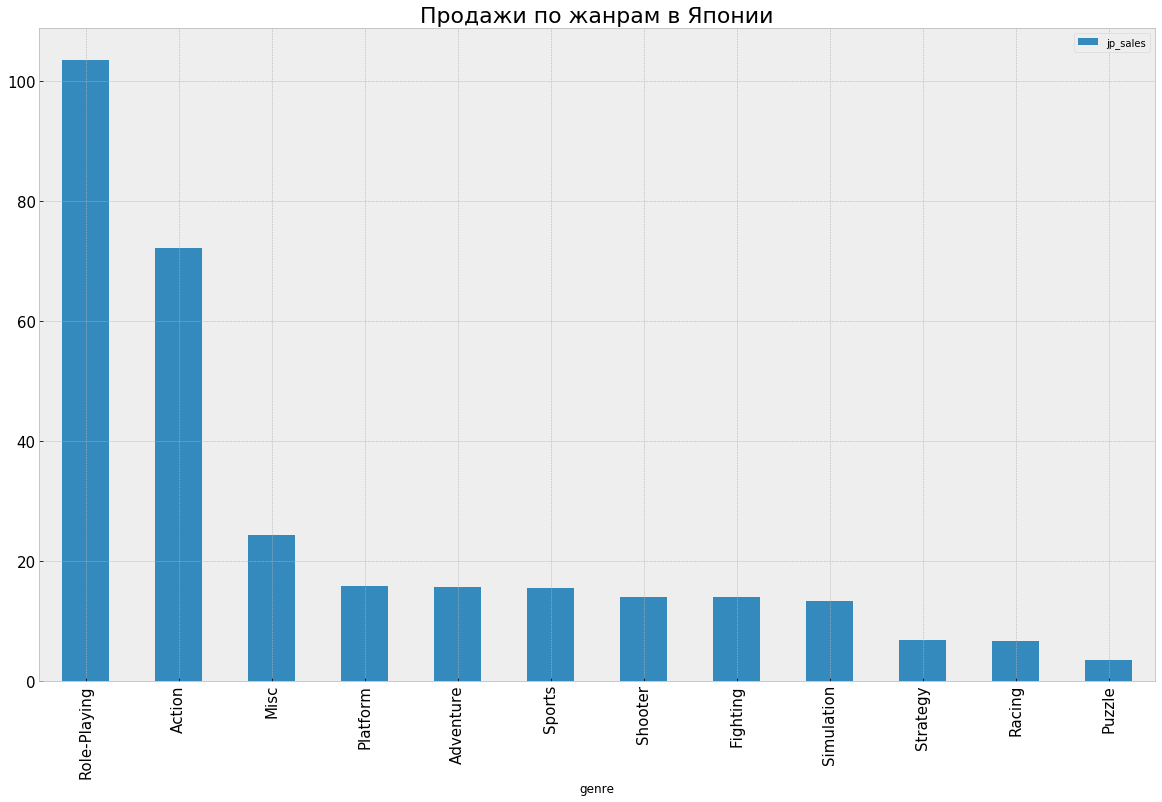

In [38]:
for key,value in ganre_dict.items():
    df_new.groupby('genre')[[key]].sum().sort_values(by = [key], ascending = False)\
    .plot.bar(grid=True,figsize=(20, 12), fontsize=15)
    plt.title(value['title'],fontsize=22)
    plt.show()

**Группировка продаж по жанрам показывает практически полное сходство для Северной Америки и Европы - Топ-5 для Америки: 'Action', 'Shooter', 'Sports', 'Misc', 'Role-Playing', для Европы: 'Action', 'Shooter', 'Sports', 'Role-Playing', 'Misc' - лишь поменялись местами 'Role-Playing' и 'Misc'. В Японии доли продаж распределены совсем иначе: 'Role-Playing', 'Action', 'Misc', 'Platform', 'Adventure'**

<a id="step4.3"></a>
### 3. Влияние рейтинга ESRB<a class="tocSkip">

**Построим диаграмму зависимости продаж от рейтинга ESRB по регионам.**

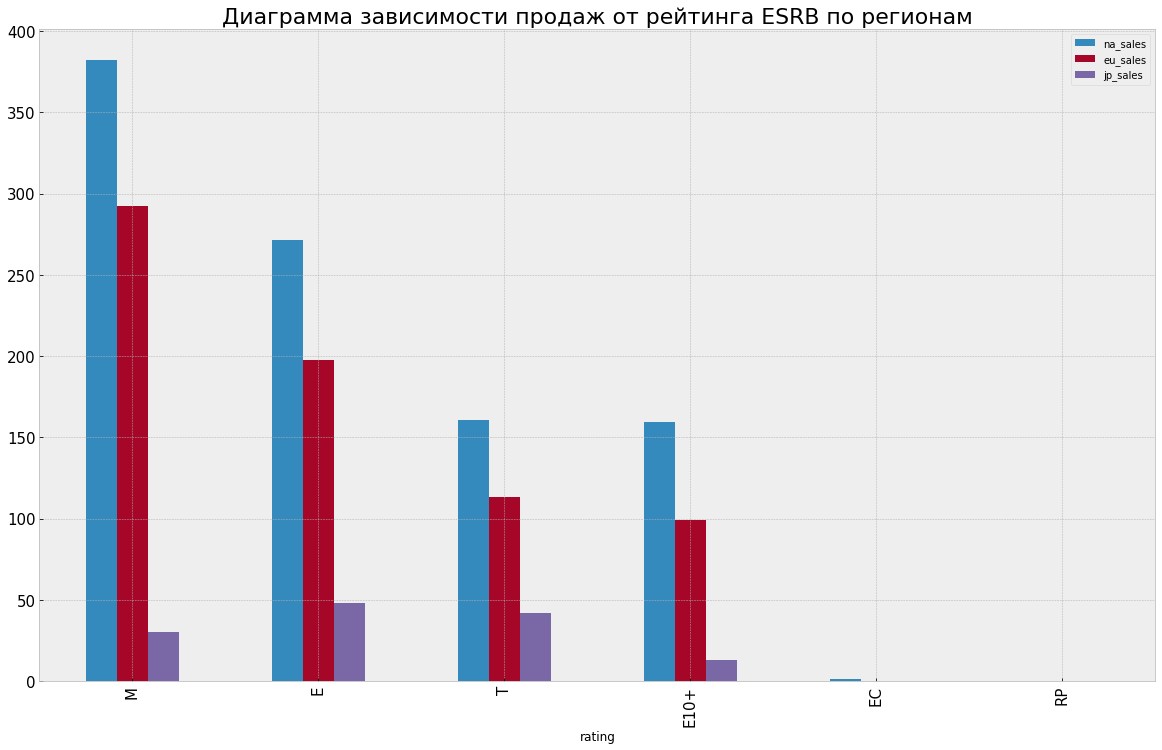

In [39]:
 df_new.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum().sort_values(by = ['na_sales'],\
                                        ascending = False).plot.bar(grid=True,figsize=(20, 12),fontsize=15)
plt.title('Диаграмма зависимости продаж от рейтинга ESRB по регионам',fontsize=22)
plt.show()

**На диаграмме мы видим, что объемы продаж игр с различными рейтингами отличаются, при чем снова данные для Северной Америки и Европы схожи и отличются от Японии. Я думаю: мы можем сказать, что рейтинг ESRB оказывает (хотя, вероятно, не первостепенное) влияние на продажи видеоигр.**

<a id="step5"></a>
## Проверка гипотез<a class="tocSkip">

<a id="step5.1"></a>
### 1.Гипотеза 'средние пользовательские рейтинги платформ Xbox One и PC одинаковые'<a class="tocSkip">

**Принимаем в качестве нулевой гипотезы  'средние пользовательские рейтинги платформ Xbox One и PC одинаковые', иначе говоря "рейтинги равны", что соответсвует правилу: "нулевую гипотезу нужнно формулировать так, чтобы можно было использовать знак равенства". Альтернативная гипотеза - 'средние пользовательские рейтинги платформ Xbox One и PC различаются.**

**Это гипотеза о равенстве среднего двух генеральных совокупностей, соответственно применяю метод scipy.stats.ttest_ind ().**

**Создадим переменные 'XOne' и 'PC'.**

In [40]:
XOne = df_new.query('platform == "XOne" and user_score != "NaN"')['user_score']

In [41]:
PC = df_new.query('platform == "PC" and user_score != "NaN"')['user_score']

**Расчитаем дисперсию для переменных.**

In [42]:
XOne.var()

1.9069968429360695

In [43]:
PC.var()

2.450446015110894

**Дисперсии не равны, значит нужно указать параметр equal_var = False.**

**Зададим критический уровень статистической значимости.**

In [44]:
alpha = 0.05

In [45]:
results = st.ttest_ind(XOne, PC, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.9801634129117883
Не получилось отвергнуть нулевую гипотезу


**Таким образом, мы можем считать гипотезу 'средние пользовательские рейтинги платформ Xbox One и PC одинаковые' вероятной.**


<a id="step5.2"></a>
### 2. Гипотеза 'cредние пользовательские рейтинги жанров Action и Sports разные.'<a class="tocSkip">

**Принимаем в качестве нулевой гипотезы  'средние пользовательские рейтинги жанров Action и Sports одинаковые', иначе говоря "рейтинги равны", что соответсвует правилу: "нулевую гипотезу нужнно формулировать так, чтобы можно было использовать знак равенства". Альтернативная гипотеза - 'средние пользовательские рейтинги жанров Action и Sports разные.**

**Создадим переменные 'Action' и 'Sports'.**

In [46]:
Action = df_new.query('genre == "Action" and user_score != "NaN"')['user_score']

In [47]:
Sports = df_new.query('genre == "Sports" and user_score != "NaN"')['user_score']

**Расчитаем дисперсию для переменных.**

In [48]:
Action.var()

1.8501475426606517

In [49]:
Sports.var()

2.8356344151248614

**Дисперсии не равны, значит нужно указать параметр equal_var = False.**

**Зададим критический уровень статистической значимости.**

In [50]:
alpha = 0.05

In [51]:
results = st.ttest_ind(Action, Sports, equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.4516152467844418e-15
Отвергаем нулевую гипотезу


**Исходя из этого, мы можем сказать, что данные выборки не противоречат гипотезе 'cредние пользовательские рейтинги жанров Action и Sports разные.'**

<a id="step6"></a>
## Общий вывод

**В ходе выполнения данного проекта нами были проанализированы исторические данные о продажах игр из открытых источников, оценки пользователей и экспертов, жанры и платформы. Мы получили следующие результаты по данным со всего мира перспективные платформы на 2017 год - 'PS4', 'XOne' и 'PС'. Лидирующие по продажам жанры - 'Action', 'Shooter' и 'Sports'. Если оценивать данные для регионов в отдельности, тогда лучшие продажи в Северной Америке у платформ  'X360', 'PS3', 'Wii', 'PS4', 'XOne' для Европы: 'PS3', 'X360', 'PS4', 'PC', 'Wii'. Для Японии совершенно другие резуьтаты: '3DS', 'PS3', 'PSP', 'DS' и 'PSV' сходство с предыдущими - только 'PS3'. Распределение долей продаж по жанрам показывает практически полное сходство для Северной Америки и Европы - Топ-5 для Америки: 'Action', 'Shooter', 'Sports', 'Misc', 'Role-Playing', для Европы: 'Action', 'Shooter', 'Sports', 'Role-Playing', 'Misc' - лишь поменялись местами 'Role-Playing' и 'Misc'. В Японии снова все совсем иначе: 'Role-Playing', 'Action', 'Misc', 'Platform', 'Adventure'. Таким бразом мы можем сказать, что предпочтения пользователей из Северной Америки и Европы практически одинаковы, а у японцев сильно отличаются, но есть позиции попадающие в Топ и там и там. В результате проведенной работы можно сделать  вывод: при определении наиболее перспективных для продвижения продуктов нужно руководствоваться  не только объемом продаж, но и динамикой изменения продаж игр по годам - это позволит отсечь игры, теряющие популярность. Кроме того нами отмечено, что на продажи игр оказывают сильное влияние оценки критиков и, возможно, рейтинг ESRB, а отзывы пользователей - напротив, несущественны (и даже небольшая отрицательная корреляция -0,0689). В дальнейшем результаты исследования могут помочь в определении потенциально популярного продуктаыыы и планировании рекламной кампании.**